In [1]:
from yamlu import ls
from yamlu.coco_read import CocoReader
from pathlib import Path
import cv2
from modules.utils import *
from modules.eval import *

dataset_path = Path("../BPMN to XML/data/hdBPMN-COCO")
ls(dataset_path)


bpmn_reader = CocoReader(
    dataset_root=dataset_path,
    arrow_categories=["sequenceFlow", "messageFlow", "dataAssociation"],
)


test_anot = bpmn_reader.parse_split("test")

c:\Users\kofb\AppData\Local\anaconda3\envs\newBPMN\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 92/92 [00:00<00:00, 123.52it/s]


In [2]:
from torchvision import transforms

transformation_test = transforms.Compose([
    #transforms.Resize((new_size[1], new_size[0])),
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])


In [6]:
from torch.utils.data.dataloader import default_collate
import random
from modules.dataset_loader import collate_fn,create_loader
import torch
from torch.utils.data import DataLoader, Subset

new_size = (1333,1333)
model_type='arrow'
test_loader = create_loader(new_size,transformation_test,test_anot, batch_size=1, model_type = model_type)

original_test_dataset = test_loader.dataset
indices = list(range(5))
subset_test_dataset = Subset(original_test_dataset, indices)
subset_test_loader = DataLoader(subset_test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)



Loaded 92 annotations.


In [7]:
from modules.train import get_faster_rcnn_model, get_arrow_model
import torch

# Function to load the models only once and use session state to keep track of it
def load_object_models(model_to_load, model_dict):
  # Adjusted to pass the class_dict directly
  model = get_faster_rcnn_model(len(model_dict))

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  # Load the model weights
  model.load_state_dict(torch.load('./'+ model_to_load, map_location=device))


  model.to(device)

  return model

def load_arrow_models(model_to_load, arrow_dict):
  model = get_arrow_model(len(arrow_dict),2)

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  # Load the model weights
  model.load_state_dict(torch.load('./'+ model_to_load, map_location=device))


  model.to(device)

  return model

In [10]:
from modules.eval import main_evaluation

model_type = 'arrow'
model_dict = arrow_dict

results = {}
model_name = 'model_arrow.pth'
model = load_arrow_models(model_name, model_dict)
labels_precision, precision, recall, f1_score, key_accuracy, reverted_accuracy = main_evaluation(model, test_loader,score_threshold=0.5, iou_threshold=0.5, distance_threshold=10, key_correction=False, model_type=model_type)
print("\n",model_name)
print(f"Labels_precision: {labels_precision:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}, Key Accuracy: {key_accuracy:.4f}, Reverted Accuracy: {reverted_accuracy:.4f}")
results[model_name] = [labels_precision, precision, recall, f1_score, key_accuracy, reverted_accuracy]

Testing... : 100%|██████████| 92/92 [06:06<00:00,  3.98s/it]


 model_arrow.pth
Labels_precision: 0.9826, Precision: 0.8771, Recall: 0.9444, F1 Score: 0.9095, Key Accuracy: 0.6987, Reverted Accuracy: 0.0208


In [11]:
from modules.eval import evaluate_model_by_class

class_precision, class_recall, class_f1_score = evaluate_model_by_class(model, subset_test_loader, model_dict, score_threshold=0.7, iou_threshold=0.5)
print(f"Class Precision: {class_precision}")
print(f"Class Recall: {class_recall}")
print(f"Class F1 Score: {class_f1_score}")

Testing... : 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

Class Precision: {'background': 0, 'sequenceFlow': 0.9032258064516129, 'dataAssociation': 0.0, 'messageFlow': 0}
Class Recall: {'background': 0, 'sequenceFlow': 0.9491525423728814, 'dataAssociation': 0, 'messageFlow': 0}
Class F1 Score: {'background': 0, 'sequenceFlow': 0.9256198347107438, 'dataAssociation': 0, 'messageFlow': 0}


In [8]:
from torch.utils.data.dataloader import default_collate
import random
from modules.dataset_loader import collate_fn,create_loader
import torch
from torch.utils.data import DataLoader, Subset

new_size = (1333,1333)
model_type='object'
test_loader = create_loader(new_size,transformation_test,test_anot, batch_size=1, model_type = model_type)

original_test_dataset = test_loader.dataset
indices = list(range(5))
subset_test_dataset = Subset(original_test_dataset, indices)
subset_test_loader = DataLoader(subset_test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)



Loaded 92 annotations.


In [9]:
from modules.eval import main_evaluation

results = {}
model_name = 'model_object.pth'
model = load_object_models(model_name, model_dict)


labels_precision, precision, recall, f1_score, key_accuracy, reverted_accuracy = main_evaluation(model, subset_test_loader,score_threshold=0.7, iou_threshold=0.5, distance_threshold=10, key_correction=False, model_type=model_type)
print(model_name)
print(f"Labels_precision: {labels_precision:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}, Key Accuracy: {key_accuracy:.4f}, Reverted Accuracy: {reverted_accuracy:.4f}")
results[model_name] = [labels_precision, precision, recall, f1_score, key_accuracy, reverted_accuracy]

Testing... : 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]

model_object.pth
Labels_precision: 1.0000, Precision: 0.9655, Recall: 0.9825, F1 Score: 0.9739, Key Accuracy: 0.0000, Reverted Accuracy: 0.0000


                Class  Precision_Model_split  Recall_Model_split  \
0                task               0.967742            0.981067   
1    exclusiveGateway               0.943396            0.955414   
2               event               0.946108            0.929412   
3     parallelGateway               0.926829            0.934426   
4        sequenceFlow               0.936678            0.936678   
5        messageEvent               0.923077            0.952381   
6                pool               0.745342            0.960000   
7                lane               0.855422            0.710000   
8          dataObject               0.865169            0.956522   
9     dataAssociation               0.749206            0.749206   
10        messageFlow               0.728814            0.728814   
11          dataStore               1.000000            0.640000   
12  eventBasedGateway               0.727273            0.727273   
13         timerEvent               0.791667    

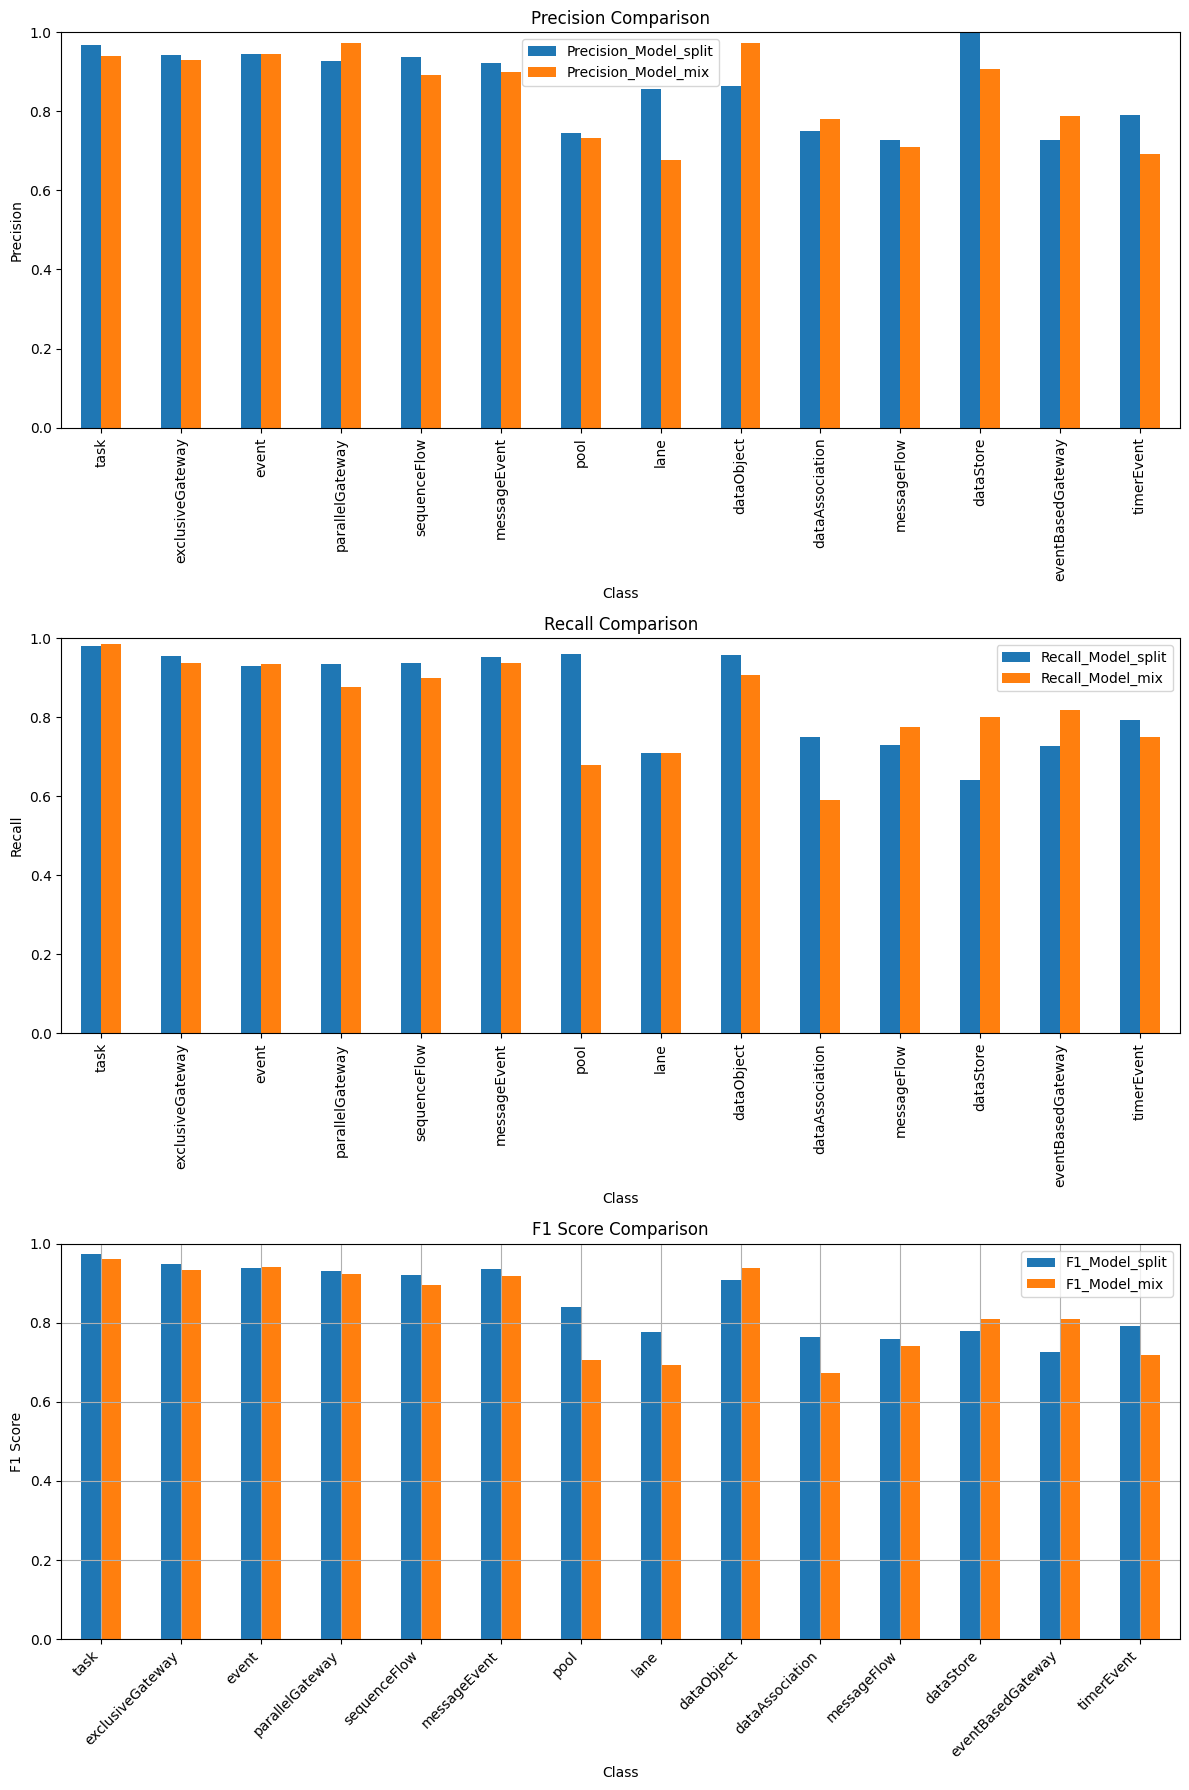

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data for Model_split and Model_full
classes = [
    'task', 'exclusiveGateway', 'event', 'parallelGateway', 'sequenceFlow', 'messageEvent', 
    'pool', 'lane', 'dataObject', 'dataAssociation', 'messageFlow', 'dataStore',  
    'eventBasedGateway', 'timerEvent'
]

# Model_full data
precision_full = [
    0.9402730375426621, 0.930379746835443, 0.9464285714285714, 0.9727272727272728, 0.8908794788273615, 
    0.9007633587786259, 0.7327586206896551, 0.6761904761904762, 0.9733333333333334, 0.7815126050420168, 
    0.7098445595854922, 0.9083333333333334, 0.7890909090909091, 0.6923076923076923
]

recall_full = [
    0.9839285714285714, 0.9363057324840764, 0.9352941176470588, 0.8770491803278688, 0.899671052631579, 
    0.9365079365079365, 0.68, 0.71, 0.906832298136646, 0.5904761904761905, 0.7740112994350282, 0.80, 
    0.8190909090909091, 0.75
]

f1_full = [
    0.9616055846422339, 0.9333333333333332, 0.9408284023668638, 0.9224137931034483, 0.8952536824877251, 
    0.9182879377431906, 0.7053941908713692, 0.6926829268292682, 0.9389067524115757, 0.6726943942133816, 
    0.7405405405405405, 0.8087755102040817, 0.8090909090909091, 0.7199999999999999
]

# Updated Model_split data
precision_split = [
    0.967741935483871, 0.9433962264150944, 0.9461077844311377, 0.926829268292683, 0.9366776315789473, 
    0.9230769230769231, 0.7453416149068323, 0.8554216867469879, 0.8651685393258427, 0.7492063492063492, 
    0.7288135593220338, 1.0, 0.7272727272727273, 0.7916666666666666
]

recall_split = [
    0.9810671256454389, 0.9554140127388535, 0.9294117647058824, 0.9344262295081968, 0.9366776315789473, 
    0.9523809523809523, 0.96, 0.71, 0.9565217391304348, 0.7492063492063492, 
    0.7288135593220338, 0.64, 0.7272727272727273, 0.7916666666666666
]

f1_split = [
    0.9743589743589743, 0.949367088607595, 0.9376854599406529, 0.9306122448979592, 0.9218939700526103, 
    0.9375, 0.8391608391608391, 0.7759562841530054, 0.9085545722713865, 0.7637540453074433, 
    0.7588235294117648, 0.7804878048780487, 0.7272727272727273, 0.7916666666666666
]

# Create DataFrame for comparison
data = {
    'Class': classes,
    'Precision_Model_split': precision_split,
    'Recall_Model_split': recall_split,
    'F1_Model_split': f1_split,
    'Precision_Model_mix': precision_full,
    'Recall_Model_mix': recall_full,
    'F1_Model_mix': f1_full,
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Plotting the data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# Precision comparison
df.plot(x='Class', y=['Precision_Model_split', 'Precision_Model_mix'], kind='bar', ax=axes[0])
axes[0].set_title('Precision Comparison')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0, 1)

# Recall comparison
df.plot(x='Class', y=['Recall_Model_split', 'Recall_Model_mix'], kind='bar', ax=axes[1])
axes[1].set_title('Recall Comparison')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0, 1)

# F1 Score comparison
df.plot(x='Class', y=['F1_Model_split', 'F1_Model_mix'], kind='bar', ax=axes[2])
axes[2].set_title('F1 Score Comparison')
axes[2].set_ylabel('F1 Score')
axes[2].set_ylim(0, 1)


plt.tight_layout()
plt.show()


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the data from the provided .txt file
file_path = './study/model_Adam_30ep_4batch_trainval_blur02.0_crop02.0_flip03.0_withkey.txt'

# Define column names based on the order provided by the user
columns = ["epoch", "epoch_avg_losses", "epoch_avg_loss_classifier", "epoch_avg_loss_box_reg", 
           "epoch_avg_loss_objectness", "epoch_avg_loss_rpn_box_reg", "epoch_avg_loss_keypoints", 
           "epoch_precision", "epoch_recall", "epoch_f1_score", "average_test_loss"]

# Read the data from the file
df = pd.read_csv(file_path, header=None, names=columns)


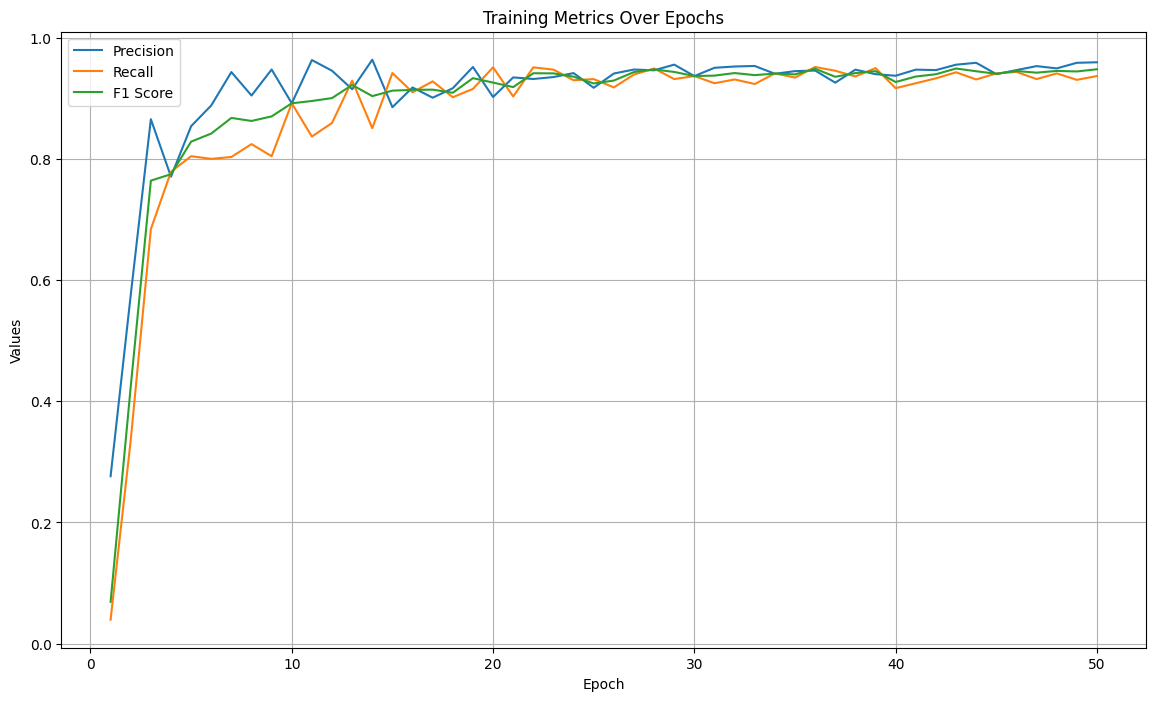

In [19]:
# Plot the data
plt.figure(figsize=(14, 8))

# Plotting the metrics
plt.plot(df['epoch'], df['epoch_precision'], label='Precision')
plt.plot(df['epoch'], df['epoch_recall'], label='Recall')
plt.plot(df['epoch'], df['epoch_f1_score'], label='F1 Score')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

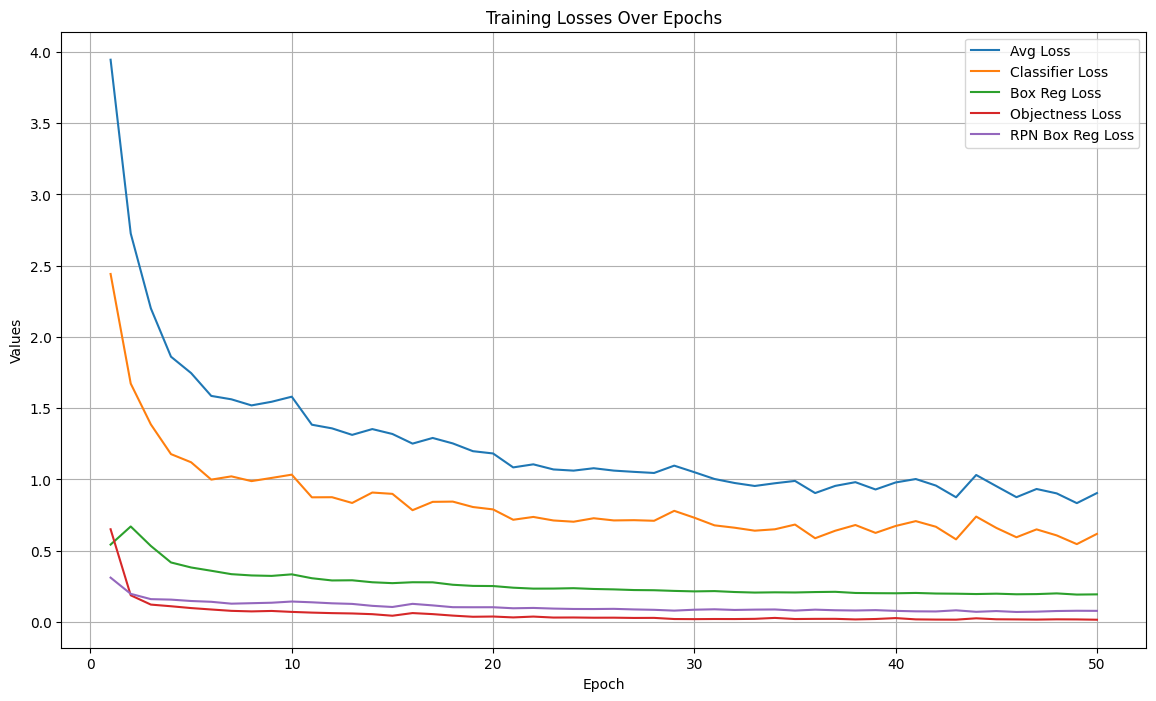

In [22]:
# Plot the data
plt.figure(figsize=(14, 8))

# Plotting the metrics
plt.plot(df['epoch'], df['epoch_avg_losses'], label='Avg Loss')
plt.plot(df['epoch'], df['epoch_avg_loss_classifier'], label='Classifier Loss')
plt.plot(df['epoch'], df['epoch_avg_loss_box_reg'], label='Box Reg Loss')
plt.plot(df['epoch'], df['epoch_avg_loss_objectness'], label='Objectness Loss')
plt.plot(df['epoch'], df['epoch_avg_loss_rpn_box_reg'], label='RPN Box Reg Loss')
#plt.plot(df['epoch'], df['epoch_avg_loss_keypoints'], label='Keypoints Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [3]:
%pip install ace_tools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
